# Image similarity estimation using a Siamese Network with a contrastive loss

**Author:** Mehdi<br>
**Date created:** 2021/05/06<br>
**Last modified:** 2022/09/10<br>
**Description:** Similarity learning using a siamese network trained with a contrastive loss.

## Setup

In [58]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import os
from emnist import extract_training_samples
from emnist import extract_test_samples

from keras.utils.vis_utils import plot_model

In [2]:
from keras import backend as K
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Hyperparameters

In [3]:
IMAGE_SIZE = 28
DIMENSION = 20
BATCH_SIZE = 32
EPOCHS = 100
margin = 1  # Margin for contrastive loss.

## Load the (E)MNIST dataset

In [4]:
### https://pypi.org/project/emnist/ ###
### https://stackoverflow.com/questions/51125969/loading-emnist-letters-dataset ###

images_train_val, labels_train_val = extract_training_samples('balanced')
images_test, labels_test = extract_test_samples('balanced')

print("Train Val Dataset shape:",images_train_val.shape, labels_train_val.shape)
idx = np.argsort(labels_train_val)
images_train_val_sorted = images_train_val[idx]
labels_train_val_sorted = labels_train_val[idx]
print("Sorted train val labels:",labels_train_val_sorted)

print("Test Dataset shape:",images_test.shape, labels_test.shape)
idx = np.argsort(labels_test)
images_test_sorted = images_test[idx]
labels_test_sorted = labels_test[idx]
print("Sorted test labels:",labels_test_sorted)

divide_position = 36 # labels 36 to 46 => 10 unseen
index_divide_position = labels_train_val_sorted.tolist().index(divide_position)

print("Position start of label", divide_position, ":", index_divide_position)

# Drop labels from train_val set
x_train_val = images_train_val_sorted[:index_divide_position]
y_train_val = labels_train_val_sorted[:index_divide_position]

print("Train Val Dataset shape with droped unseen labels:",x_train_val.shape, y_train_val.shape)
print("Traub vak labels after drop:",y_train_val)

#shuffle train_val x and y but with the same order

xy = list(zip(x_train_val, y_train_val))

random.shuffle(xy)

x_train_val, y_train_val = zip(*xy)

# Define test dataset

x_test = images_test_sorted
y_test = labels_test_sorted

# Change the data type to a floating point format
x_train_val = np.array(x_train_val).astype("float32")
x_test = np.array(x_test).astype("float32")

y_train_val = np.array(y_train_val)
y_test = np.array(y_test)

Train Val Dataset shape: (112800, 28, 28) (112800,)
Sorted train val labels: [ 0  0  0 ... 46 46 46]
Test Dataset shape: (18800, 28, 28) (18800,)
Sorted test labels: [ 0  0  0 ... 46 46 46]
Position start of label 36 : 86400
Train Val Dataset shape with droped unseen labels: (86400, 28, 28) (86400,)
Traub vak labels after drop: [ 0  0  0 ... 35 35 35]


## Define training, validation and test sets

In [5]:
print("Train+Val len:",len(x_train_val),len(y_train_val))
print("Test len:",len(x_test),len(y_test))

# 50 training data, 30% validation data, 20% test data 

x_train, x_val = x_train_val[:47000], x_train_val[47000:75200]
y_train, y_val = y_train_val[:47000], y_train_val[47000:75200]

Train+Val len: 86400 86400
Test len: 18800 18800


In [6]:
print("Train len:",len(x_train),len(y_train))
print("Val len:",len(x_val),len(y_val))
print("Test len:",len(x_test),len(y_test))

Train len: 47000 47000
Val len: 28200 28200
Test len: 18800 18800


In [7]:
y_train.shape

(47000,)

## Create pairs of images

We will train the model to differentiate between digits of different classes. For
example, digit `0` needs to be differentiated from the rest of the
digits (`1` through `9`), digit `1` - from `0` and `2` through `9`, and so on.
To carry this out, we will select N random images from class A (for example,
for digit `0`) and pair them with N random images from another class B
(for example, for digit `1`). Then, we can repeat this process for all classes
of digits (until digit `9`). Once we have paired digit `0` with other digits,
we can repeat this process for the remaining classes for the rest of the digits
(from `1` until `9`).

In [8]:

def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    min_value = min(y)
    digit_indices = [np.where(y == i)[0] for i in range(min_value, num_classes)]
    
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1-min_value])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0,len(np.unique((y)))-1)
        while label2 == label1: 
            label2 = random.randint(0,len(np.unique((y)))-1)


        idx2 = random.choice(digit_indices[label2])
   
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


In [9]:
# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

We get:

**pairs_train.shape = (150400, 2, 28, 28)**

- We have 150400 pairs
- Each pair contains 2 images
- Each image has shape `(28, 28)`

Split the training pairs

In [10]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

Split the validation pairs

In [11]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

Split the test pairs

In [12]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]


## Visualize pairs and their labels

In [13]:

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


Inspect training pairs

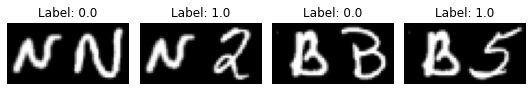

In [14]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

Inspect validation pairs

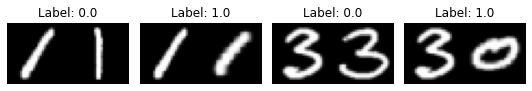

In [15]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

Inspect test pairs

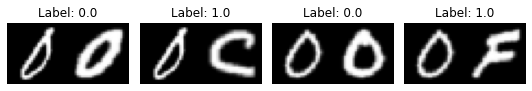

In [16]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

## Define the model

There are two input layers, each leading to its own network, which
produces embeddings. A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network.

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                              monitor='val_loss',
                              mode='min',
                              verbose = 1,
                              restore_best_weights=True)
callback=[early_stopping]

In [18]:
# CONTRASTIVE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(DIMENSION, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)

# define model for each loss function
siamese1 = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [19]:
# DICE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x2 = tf.keras.layers.BatchNormalization()(input2)
x2 = layers.Conv2D(32, (3, 3), activation="relu")(x2)
x2 = layers.AveragePooling2D(pool_size=(2, 2))(x2)
x2 = layers.Conv2D(32, (3, 3), activation="relu")(x2)
x2 = layers.AveragePooling2D(pool_size=(2, 2))(x2)
x2 = layers.Flatten()(x2)

x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = layers.Dense(47, activation="relu")(x2)
embedding_network_2 = keras.Model(input2, x2)


input_1_2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1_2 = embedding_network_2(input_1_2)
tower_2_2 = embedding_network_2(input_2_2)

merge_layer_2 = layers.Lambda(euclidean_distance)([tower_1_2, tower_2_2])
normal_layer_2 = tf.keras.layers.BatchNormalization()(merge_layer_2)
output_layer_2 = layers.Dense(1, activation="sigmoid")(normal_layer_2)
siamese2 = keras.Model(inputs=[input_1_2, input_2_2], outputs=output_layer_2)

In [20]:
# BCE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input3 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x3 = tf.keras.layers.BatchNormalization()(input3)
x3 = layers.Conv2D(32, (3, 3), activation="relu")(x3)
x3 = layers.AveragePooling2D(pool_size=(2, 2))(x3)
x3 = layers.Conv2D(32, (3, 3), activation="relu")(x3)
x3 = layers.AveragePooling2D(pool_size=(2, 2))(x3)
x3 = layers.Flatten()(x3)

x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = layers.Dense(47, activation="relu")(x3)
embedding_network_3 = keras.Model(input3, x3)


input_1_3 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_3 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1_3 = embedding_network_3(input_1_3)
tower_2_3 = embedding_network_3(input_2_3)

merge_layer_3 = layers.Lambda(euclidean_distance)([tower_1_3, tower_2_3])
normal_layer_3 = tf.keras.layers.BatchNormalization()(merge_layer_3)
output_layer_3 = layers.Dense(1, activation="sigmoid")(normal_layer_3)
siamese3 = keras.Model(inputs=[input_1_3, input_2_3], outputs=output_layer_3)

In [21]:
# BCE + DICE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input4 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x4 = tf.keras.layers.BatchNormalization()(input4)
x4 = layers.Conv2D(32, (3, 3), activation="relu")(x4)
x4 = layers.AveragePooling2D(pool_size=(2, 2))(x4)
x4 = layers.Conv2D(32, (3, 3), activation="relu")(x4)
x4 = layers.AveragePooling2D(pool_size=(2, 2))(x4)
x4 = layers.Flatten()(x4)

x4 = tf.keras.layers.BatchNormalization()(x4)
x4 = layers.Dense(47, activation="relu")(x4)
embedding_network_4 = keras.Model(input4, x4)


input_1_4 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_4 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1_4 = embedding_network_4(input_1_4)
tower_2_4 = embedding_network_4(input_2_4)

merge_layer_4 = layers.Lambda(euclidean_distance)([tower_1_4, tower_2_4])
normal_layer_4 = tf.keras.layers.BatchNormalization()(merge_layer_4)
output_layer_4 = layers.Dense(1, activation="sigmoid")(normal_layer_4)
siamese4 = keras.Model(inputs=[input_1_4, input_2_4], outputs=output_layer_4)

In [22]:
# HINGE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input5 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x5 = tf.keras.layers.BatchNormalization()(input5)
x5 = layers.Conv2D(32, (3, 3), activation="relu")(x5)
x5 = layers.AveragePooling2D(pool_size=(2, 2))(x5)
x5 = layers.Conv2D(32, (3, 3), activation="relu")(x5)
x5 = layers.AveragePooling2D(pool_size=(2, 2))(x5)
x5 = layers.Flatten()(x5)

x5 = tf.keras.layers.BatchNormalization()(x5)
x5 = layers.Dense(47, activation="relu")(x5)
embedding_network_5 = keras.Model(input5, x5)


input_1_5 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_5 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1_5 = embedding_network_5(input_1_5)
tower_2_5 = embedding_network_5(input_2_5)

merge_layer_5 = layers.Lambda(euclidean_distance)([tower_1_5, tower_2_5])
normal_layer_5 = tf.keras.layers.BatchNormalization()(merge_layer_5)
output_layer_5 = layers.Dense(1, activation="sigmoid")(normal_layer_5)
siamese5 = keras.Model(inputs=[input_1_5, input_2_5], outputs=output_layer_5)

## Define the contrastive Loss

In [23]:
def contrastive_loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )   

        """
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * margin_square + (y_true) * square_pred
        )
        """

    return contrastive_loss


## Define the Dice Loss
Code: https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras

![Dice Loss](./img/Dice_Loss.png)

In [24]:
# Dice Loss
def dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def dice_coef(y_true, y_pred, smooth=100):        
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return dice
    
    def dice_coef_loss(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred)
    
    return dice_coef_loss

## Define the Binary Cross Entropy Loss
Code: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

![BCE Loss](./img/BCE_Loss.png)

In [25]:
# BCE_Loss
def BCE_loss(margin=1): #ignore margin

    def binary_cross_entropy_loss(y_true, y_pred):
        BCE =  K.binary_crossentropy(y_true, y_pred)
        return BCE
    
    return binary_cross_entropy_loss

## Define the BCE + Dice Loss
Paper: https://ieeexplore.ieee.org/abstract/document/10023508?casa_token=_zhnKjSaYgYAAAAA:zZ0oLIx6Yoc56OeYEdvdJfwA0FLyQyhg3NNmd8YOUTzPLLgn5hK8ZoJ4UUAwH_9Dn55YLj2fQbk 
Code: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

![Dice Loss](./img/BCE_Loss.png)
![Dice Loss](./img/Dice_Loss.png)
![Dice Loss](./img/BCE_Dice_Loss.png)

In [26]:
# BCE_Dice_Loss
def BCE_dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def dice_coef_loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
        return dice

    
    def binary_cross_entropy_loss(y_true, y_pred):
        BCE =  K.binary_crossentropy(y_true, y_pred)
        return BCE
    

    def BCE_dice_coef_loss(y_true, y_pred):
        dice_loss = 1 - dice_coef_loss(y_true, y_pred)
        BCE =  binary_cross_entropy_loss(y_true, y_pred)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE
    
    return BCE_dice_coef_loss

## Compile the model with the contrastive loss

In [27]:
siamese1.compile(loss=contrastive_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 20)           39064       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

## Compile the model with the dice loss

In [28]:
siamese2.compile(loss=dice_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 47)           50419       ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['model_2[0][0]',          

## Compile the model with the BCE loss

In [29]:
siamese3.compile(loss=BCE_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 47)           50419       ['input_8[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 1)            0           ['model_4[0][0]',          

## Compile the model with the BCE + dice loss

In [30]:
siamese4.compile(loss=BCE_dice_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_6 (Functional)           (None, 47)           50419       ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 lambda_3 (Lambda)              (None, 1)            0           ['model_6[0][0]',          

## Compile the model with the Hinge Loss

In [31]:
siamese5.compile(loss=tf.keras.losses.Hinge(), optimizer="Adam", metrics=["accuracy"])
siamese5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_8 (Functional)           (None, 47)           50419       ['input_14[0][0]',               
                                                                  'input_15[0][0]']               
                                                                                                  
 lambda_4 (Lambda)              (None, 1)            0           ['model_8[0][0]',          

## Train the models

In [32]:
# Contrastive Loss
history1 = siamese1.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
2938/2938 [==============================] - 64s 21ms/step - loss: 0.2535 - accuracy: 0.4912 - val_loss: 0.2478 - val_accuracy: 0.5616
Epoch 2/100
2938/2938 [==============================] - 62s 21ms/step - loss: 0.0907 - accuracy: 0.8839 - val_loss: 0.0462 - val_accuracy: 0.9408
Epoch 3/100
2938/2938 [==============================] - 62s 21ms/step - loss: 0.0479 - accuracy: 0.9383 - val_loss: 0.0382 - val_accuracy: 0.9511
Epoch 4/100
2938/2938 [==============================] - 69s 23ms/step - loss: 0.0411 - accuracy: 0.9477 - val_loss: 0.0368 - val_accuracy: 0.9534
Epoch 5/100
2938/2938 [==============================] - 66s 22ms/step - loss: 0.0370 - accuracy: 0.9530 - val_loss: 0.0319 - val_accuracy: 0.9599
Epoch 6/100
2938/2938 [==============================] - 68s 23ms/step - loss: 0.0344 - accuracy: 0.9564 - val_loss: 0.0322 - val_accuracy: 0.9590
Epoch 7/100
2938/2938 [==============================] - 67s 23ms/step - loss: 0.0325 - accuracy: 0.9594 - val_loss: 0

In [33]:
# Dice Loss
history2 = siamese2.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
2938/2938 [==============================] - 70s 23ms/step - loss: 0.1137 - accuracy: 0.4965 - val_loss: 0.1088 - val_accuracy: 0.5000
Epoch 2/100
2938/2938 [==============================] - 66s 23ms/step - loss: 0.1087 - accuracy: 0.5000 - val_loss: 0.1082 - val_accuracy: 0.5000
Epoch 3/100
2938/2938 [==============================] - 63s 21ms/step - loss: 0.1085 - accuracy: 0.5000 - val_loss: 0.1081 - val_accuracy: 0.5000
Epoch 4/100
2938/2938 [==============================] - 63s 21ms/step - loss: 0.1085 - accuracy: 0.5000 - val_loss: 0.1081 - val_accuracy: 0.5000
Epoch 5/100
2938/2938 [==============================] - 61s 21ms/step - loss: 0.1085 - accuracy: 0.5000 - val_loss: 0.1081 - val_accuracy: 0.5000
Epoch 6/100
2938/2938 [==============================] - 61s 21ms/step - loss: 0.1085 - accuracy: 0.5000 - val_loss: 0.1081 - val_accuracy: 0.5000
Epoch 7/100
2938/2938 [==============================] - 63s 21ms/step - loss: 0.1085 - accuracy: 0.5000 - val_loss: 0

In [34]:
# BCE Loss
history3 = siamese3.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
2938/2938 [==============================] - 63s 21ms/step - loss: 0.2772 - accuracy: 0.9057 - val_loss: 0.1552 - val_accuracy: 0.9451
Epoch 2/100
2938/2938 [==============================] - 61s 21ms/step - loss: 0.1516 - accuracy: 0.9463 - val_loss: 0.1251 - val_accuracy: 0.9576
Epoch 3/100
2938/2938 [==============================] - 61s 21ms/step - loss: 0.1266 - accuracy: 0.9563 - val_loss: 0.1228 - val_accuracy: 0.9579
Epoch 4/100
2938/2938 [==============================] - 62s 21ms/step - loss: 0.1147 - accuracy: 0.9611 - val_loss: 0.1176 - val_accuracy: 0.9613
Epoch 5/100
2938/2938 [==============================] - 61s 21ms/step - loss: 0.1056 - accuracy: 0.9643 - val_loss: 0.1120 - val_accuracy: 0.9632
Epoch 6/100
2938/2938 [==============================] - 66s 22ms/step - loss: 0.0972 - accuracy: 0.9671 - val_loss: 0.1134 - val_accuracy: 0.9639
Epoch 7/100
2938/2938 [==============================] - 62s 21ms/step - loss: 0.0915 - accuracy: 0.9694 - val_loss: 0

In [35]:
# BCE + Dice Loss
history4 = siamese4.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
2938/2938 [==============================] - 63s 21ms/step - loss: 0.4428 - accuracy: 0.9031 - val_loss: 0.2315 - val_accuracy: 0.9480
Epoch 2/100
2938/2938 [==============================] - 62s 21ms/step - loss: 0.2355 - accuracy: 0.9460 - val_loss: 0.1964 - val_accuracy: 0.9548
Epoch 3/100
2938/2938 [==============================] - 62s 21ms/step - loss: 0.1943 - accuracy: 0.9567 - val_loss: 0.1888 - val_accuracy: 0.9572
Epoch 4/100
2938/2938 [==============================] - 63s 21ms/step - loss: 0.1736 - accuracy: 0.9611 - val_loss: 0.1981 - val_accuracy: 0.9565
Epoch 5/100
2938/2938 [==============================] - 64s 22ms/step - loss: 0.1587 - accuracy: 0.9655 - val_loss: 0.1667 - val_accuracy: 0.9640
Epoch 6/100
2938/2938 [==============================] - 62s 21ms/step - loss: 0.1449 - accuracy: 0.9681 - val_loss: 0.1744 - val_accuracy: 0.9616
Epoch 7/100
2938/2938 [==============================] - 62s 21ms/step - loss: 0.1384 - accuracy: 0.9698 - val_loss: 0

In [36]:
# Hinge Loss
history5 = siamese5.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
2938/2938 [==============================] - 72s 24ms/step - loss: 0.6830 - accuracy: 0.9097 - val_loss: 0.5676 - val_accuracy: 0.9496
Epoch 2/100
2938/2938 [==============================] - 67s 23ms/step - loss: 0.5663 - accuracy: 0.9443 - val_loss: 0.5484 - val_accuracy: 0.9561
Epoch 3/100
2938/2938 [==============================] - 63s 22ms/step - loss: 0.5531 - accuracy: 0.9504 - val_loss: 0.5481 - val_accuracy: 0.9539
Epoch 4/100
2938/2938 [==============================] - 64s 22ms/step - loss: 0.5506 - accuracy: 0.9512 - val_loss: 0.5469 - val_accuracy: 0.9540
Epoch 5/100
2938/2938 [==============================] - 64s 22ms/step - loss: 0.5478 - accuracy: 0.9533 - val_loss: 0.5440 - val_accuracy: 0.9566
Epoch 6/100
2938/2938 [==============================] - 62s 21ms/step - loss: 0.5482 - accuracy: 0.9524 - val_loss: 0.5439 - val_accuracy: 0.9562
Epoch 7/100
2938/2938 [==============================] - 65s 22ms/step - loss: 0.5482 - accuracy: 0.9521 - val_loss: 0

## Visualize results

In [41]:
def plt_metric(history, metric, title, has_valid=True, x = 0, y = 0):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    axs[x, y].plot(history[metric])
    if has_valid:
        axs[x, y].plot(history["val_" + metric])
        axs[x, y].legend(["train", "validation"], loc="upper left")
    axs[x, y].set_title(title)
    
    for ax in axs.flat:
        ax.set(xlabel="epoch")
        
    axs.flat[0].set(ylabel="accuracy")
    axs.flat[6].set(ylabel="accuracy")
    axs.flat[3].set(ylabel="loss")
    axs.flat[9].set(ylabel="loss")
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()
        
    axs[x,y].set_xlim([0, 100])

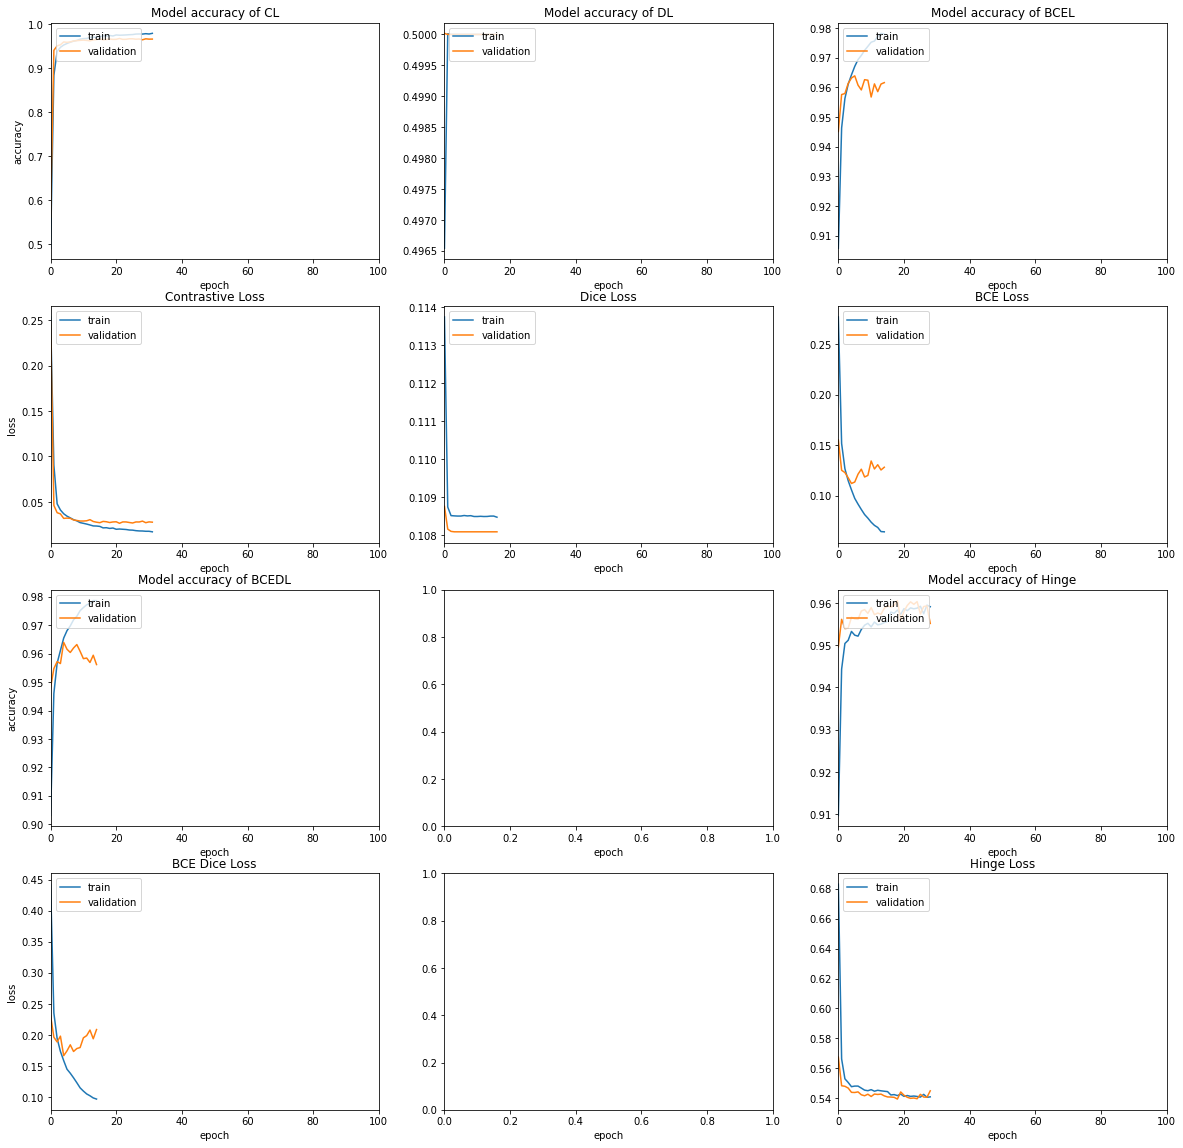

In [42]:
fig, axs = plt.subplots(4, 3)

fig.set_figheight(20)
fig.set_figwidth(20)

# Plot the accuracy of contrastive loss
plt_metric(history=history1.history, metric="accuracy", title="Model accuracy of CL", x=0 ,y=0)

# Plot the contrastive loss
plt_metric(history=history1.history, metric="loss", title="Contrastive Loss", x=1 ,y=0)

# Plot the accuracy of dice loss
plt_metric(history=history2.history, metric="accuracy", title="Model accuracy of DL",x=0 ,y=1)

# Plot the dice loss
plt_metric(history=history2.history, metric="loss", title="Dice Loss", x=1 ,y=1)

# Plot the accuracy of BCE loss
plt_metric(history=history3.history, metric="accuracy", title="Model accuracy of BCEL",x=0 ,y=2)

# Plot the BCE loss
plt_metric(history=history3.history, metric="loss", title="BCE Loss", x=1 ,y=2)

# Plot the accuracy of BCE dice loss
plt_metric(history=history4.history, metric="accuracy", title="Model accuracy of BCEDL", x=2 ,y=0)

# Plot the BCE dice loss
plt_metric(history=history4.history, metric="loss", title="BCE Dice Loss", x=3 ,y=0)

# Plot the accuracy of hinge loss
plt_metric(history=history5.history, metric="accuracy", title="Model accuracy of Hinge", x=2 ,y=2)

# Plot the hinge loss
plt_metric(history=history5.history, metric="loss", title="Hinge Loss", x=3 ,y=2)

In [48]:
def plt_metric_train(history, metric, title, has_valid=True, x = 0, y = 0):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    axs[x,y].plot(history[metric])
    
    axs[x,y].legend(["CL","DL","BCEL","BCEDL","Hinge"], loc="upper left")
    
    axs[x,y].set_title(title)
    
    for ax in axs.flat:
        ax.set(xlabel="epoch")
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()  
    
    axs[x,y].set_xlim([0, 35])
            
def plt_metric_val(history, metric, title, has_valid=True, x = 0, y = 0):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    axs[x,y].plot(history["val_" + metric])
    
    axs[x,y].legend(["CL","DL","BCEL","BCEDL","Hinge"], loc="upper left")
    
    axs[x,y].set_title(title)
        
    for ax in axs.flat:
        ax.set(xlabel="epoch")
                        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()
    
    axs[x,y].set_xlim([0, 35])

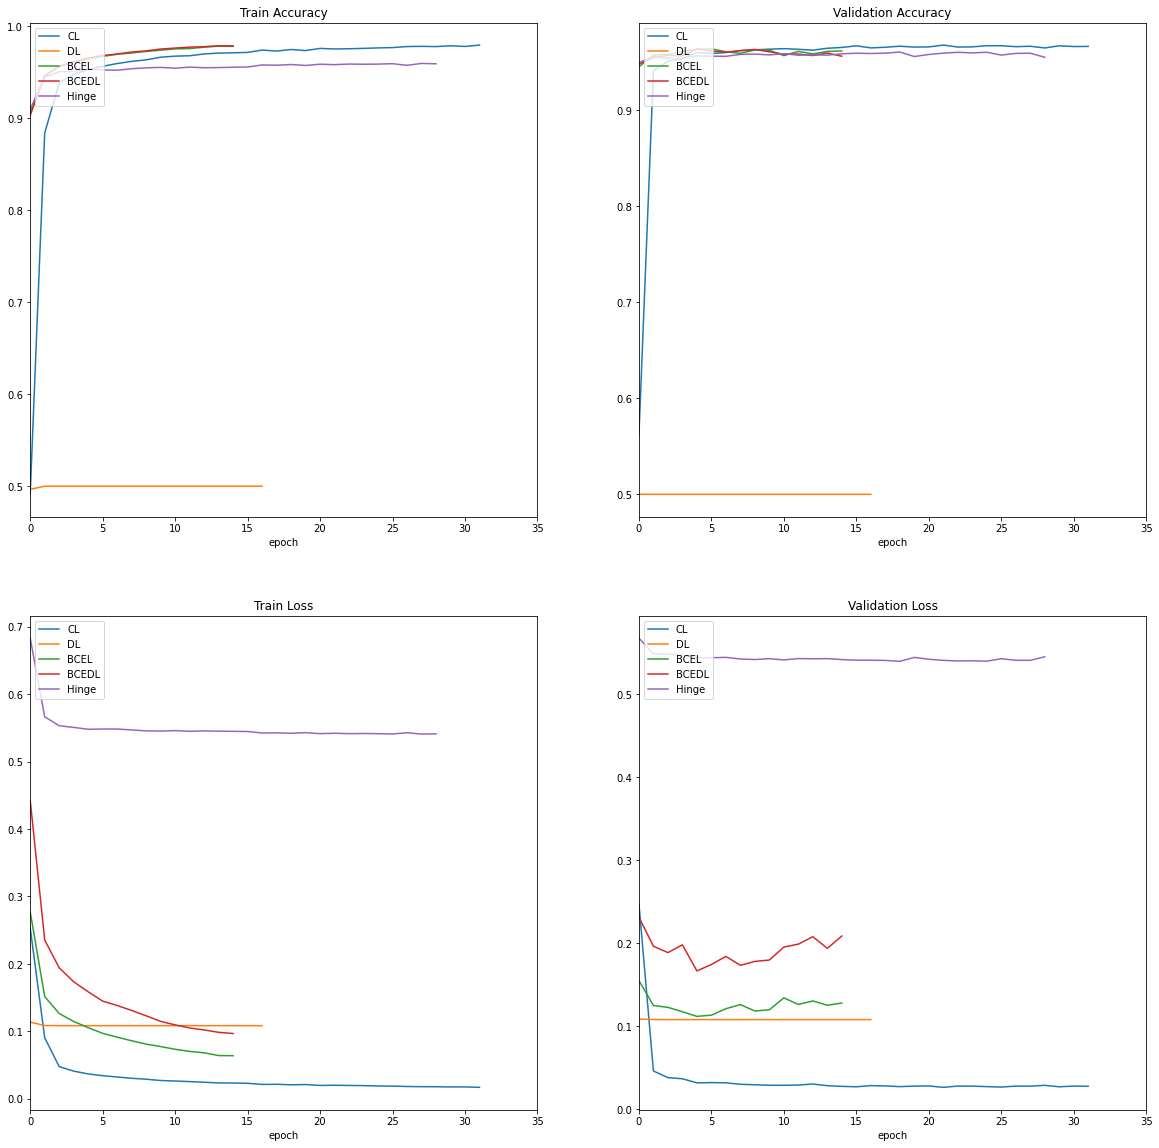

In [49]:
fig, axs = plt.subplots(2,2)

fig.set_figheight(20)
fig.set_figwidth(20)

# Plot the accuracy of contrastive loss
plt_metric_train(history=history1.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)

# Plot the accuracy of dice loss
plt_metric_train(history=history2.history, metric="accuracy", title="Train Accuracy",x=0 ,y=0)

# Plot the accuracy of BCE loss
plt_metric_train(history=history3.history, metric="accuracy", title="Train Accuracy",x=0 ,y=0)

# Plot the accuracy of BCE dice loss
plt_metric_train(history=history4.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)

# Plot the accuracy of hinge loss
plt_metric_train(history=history5.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)


# Plot the contrastive loss
plt_metric_train(history=history1.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the dice loss
plt_metric_train(history=history2.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the BCE loss
plt_metric_train(history=history3.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the BCE dice loss
plt_metric_train(history=history4.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the hinge loss
plt_metric_train(history=history5.history, metric="loss", title="Train Loss", x=1 ,y=0)


# Plot the accuracy of contrastive loss
plt_metric_val(history=history1.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)

# Plot the accuracy of dice loss
plt_metric_val(history=history2.history, metric="accuracy", title="Validation Accuracy",x=0 ,y=1)

# Plot the accuracy of BCE loss
plt_metric_val(history=history3.history, metric="accuracy", title="Validation Accuracy",x=0 ,y=1)

# Plot the accuracy of BCE dice loss
plt_metric_val(history=history4.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)

# Plot the accuracy of hinge loss
plt_metric_val(history=history5.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)


# Plot the contrastive loss
plt_metric_val(history=history1.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the dice loss
plt_metric_val(history=history2.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the BCE loss
plt_metric_val(history=history3.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the BCE dice loss
plt_metric_val(history=history4.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the hinge loss
plt_metric_val(history=history5.history, metric="loss", title="Validation Loss", x=1 ,y=1)


## Evaluate the model

In [50]:
results1 = siamese1.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results1)

1175/1175 [==============================] - 6s 5ms/step - loss: 0.0541 - accuracy: 0.9323
test loss, test acc: [0.05411035940051079, 0.9323404431343079]


In [51]:
results2 = siamese2.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results2)

1175/1175 [==============================] - 6s 5ms/step - loss: 0.1081 - accuracy: 0.5000
test loss, test acc: [0.10810849070549011, 0.5]


In [52]:
results3 = siamese3.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results3)

1175/1175 [==============================] - 6s 5ms/step - loss: 0.1936 - accuracy: 0.9295
test loss, test acc: [0.1935572773218155, 0.9295478463172913]


In [53]:
results4 = siamese4.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results4)

1175/1175 [==============================] - 6s 5ms/step - loss: 0.2877 - accuracy: 0.9335
test loss, test acc: [0.28768616914749146, 0.9335372447967529]


In [54]:
results5 = siamese5.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results5)

1175/1175 [==============================] - 6s 5ms/step - loss: 0.5723 - accuracy: 0.9278
test loss, test acc: [0.5722861886024475, 0.927765965461731]


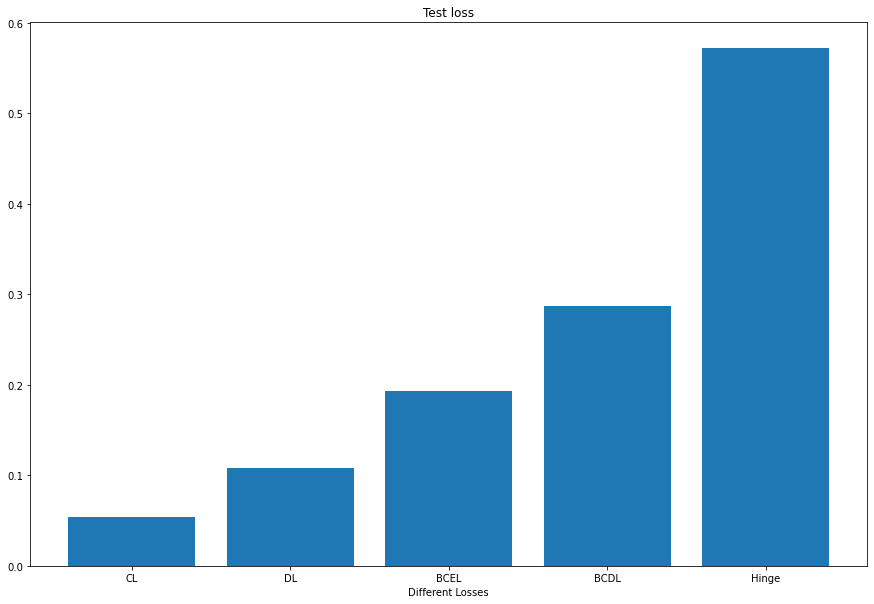

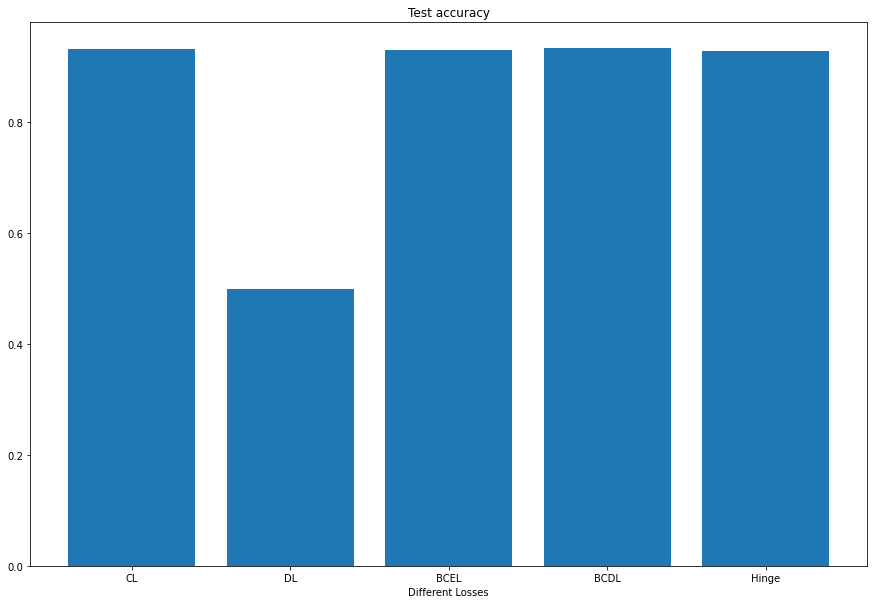

In [65]:
data = {'CL': results1[0], 'DL': results2[0], 'BCEL': results3[0],
        'BCDL': results4[0],'Hinge': results5[0]}
 
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize=(15, 10))
 
# creating the bar plot
plt.bar(courses, values)
 
plt.xlabel("Different Losses")
plt.ylabel("")
plt.title("Test loss")
plt.show()

data = {'CL': results1[1], 'DL': results2[1], 'BCEL': results3[1],
        'BCDL': results4[1],
        'Hinge': results5[1]}
 
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize=(15, 10))
 
# creating the bar plot
plt.bar(courses, values)
 
plt.xlabel("Different Losses")
plt.ylabel("")
plt.title("Test accuracy")
plt.show()

## Model

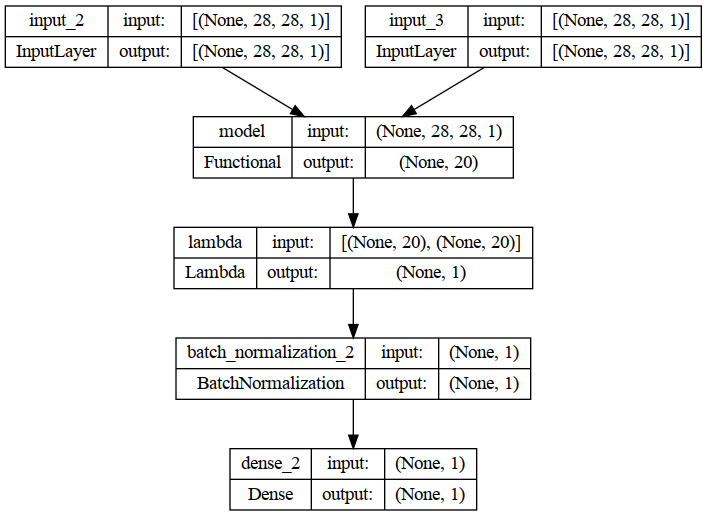

In [59]:
plot_model(siamese1, show_shapes=True, to_file='model.png')

## Visualize the predictions

1175/1175 [==============================] - 6s 5ms/step


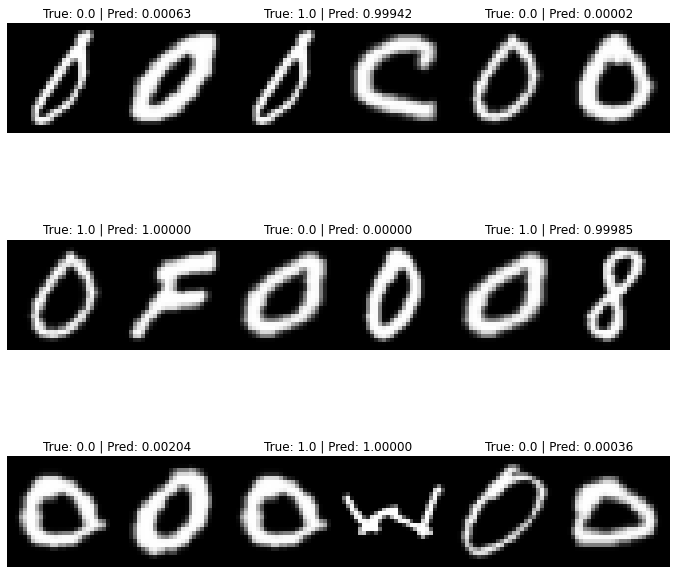

In [60]:
predictions1 = siamese1.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions1, test=True)

1175/1175 [==============================] - 6s 5ms/step


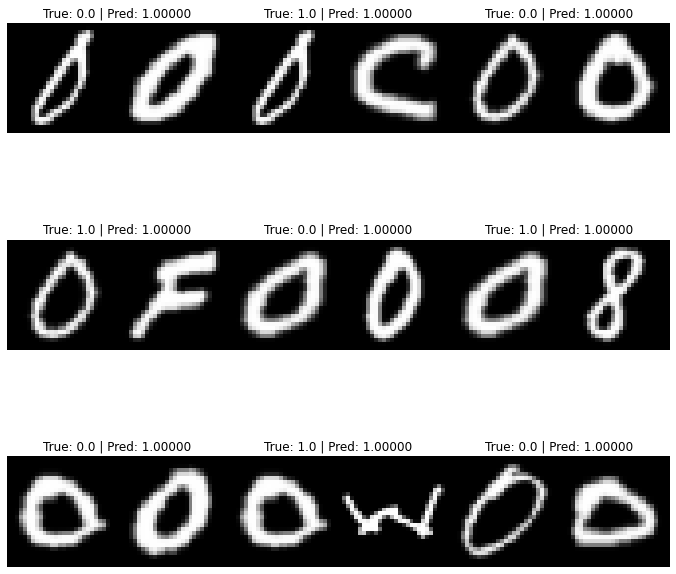

In [61]:
predictions2 = siamese2.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions2, test=True)

1175/1175 [==============================] - 6s 5ms/step


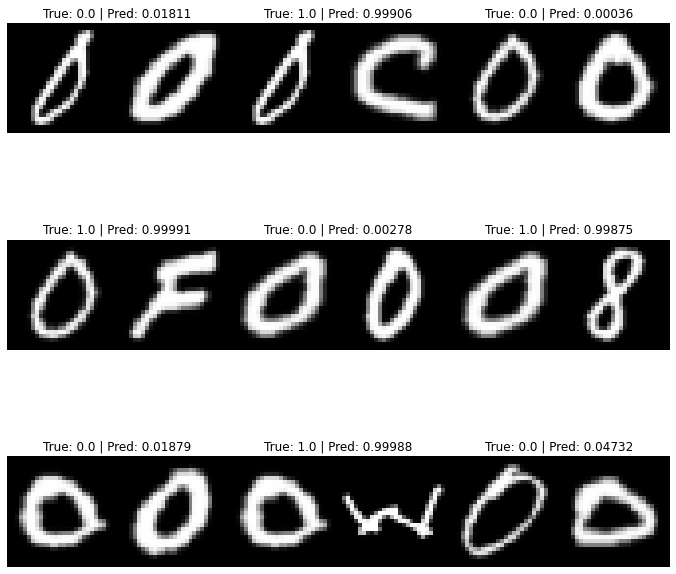

In [62]:
predictions3 = siamese3.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions3, test=True)

1175/1175 [==============================] - 6s 5ms/step


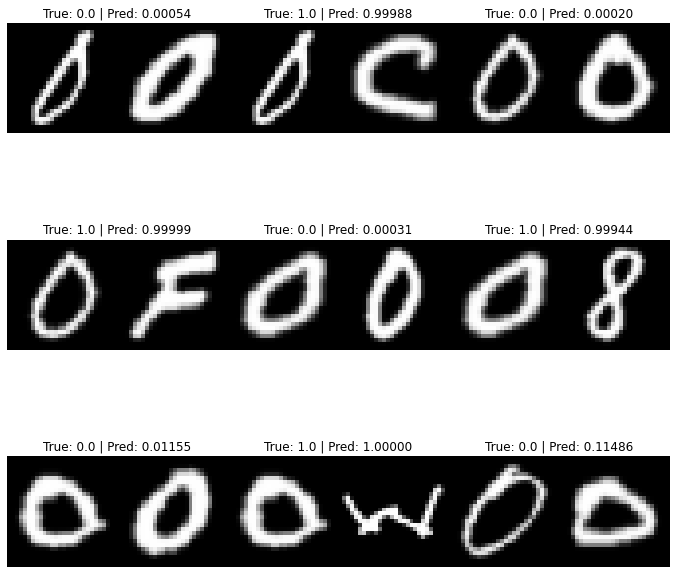

In [63]:
predictions4 = siamese4.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions4, test=True)

1175/1175 [==============================] - 6s 5ms/step


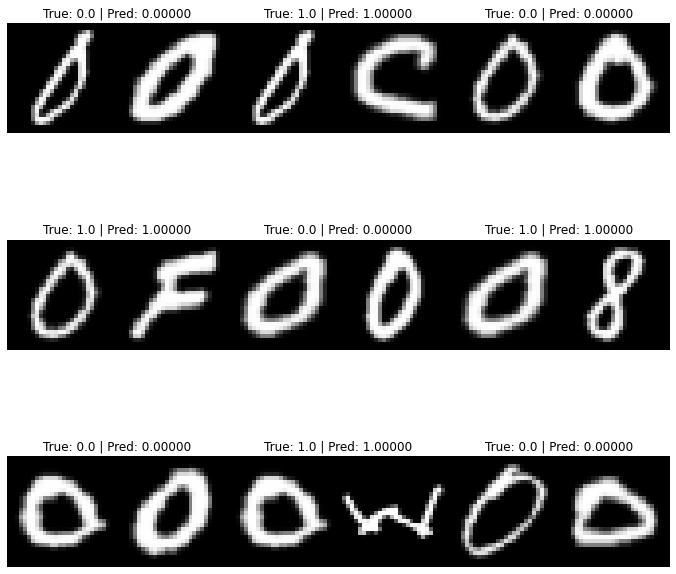

In [64]:
predictions5 = siamese5.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions5, test=True)

## Other Possible Loss Functions

### Cross Entropy with balance factor (2023)
Paper: 
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10021880 

### Join of MSE, bidirectional Kullback Leibler divergence and rank order of quality scores (2023)
Paper: 
https://dl.acm.org/doi/abs/10.1145/3597434

### Multiple negative ranking loss (2022)
Paper: 
https://arxiv.org/pdf/2203.14541.pdf

### Max margin hinge loss (2021)
Paper: 
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9414458

### Softmax cross entropy loss (2018)
Paper: 
https://www.researchgate.net/publication/326204812_Modeling_Contemporaneous_Basket_Sequences_with_Twin_Networks_for_Next-Item_Recommendation